In [21]:
import numpy as np
import os
import pandas as pd
from netCDF4 import Dataset
from scipy.interpolate import interp1d
from scipy.integrate import quad
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.collections import LineCollection
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D
import csv

In [22]:
os.listdir()

['Mod_EPP_28072020.ipynb',
 'apeep_Ck_maps_on_20170910.nc',
 'Mod_EPP_with_old_axis.ipynb',
 '.DS_Store',
 'apeep_Ck_maps_on_20170911.nc',
 'first_input.ipynb',
 'Diff_flux_20170906_orbit1.csv',
 'Diff_flux_20170907_12orbits_n1_with_ratio.csv',
 'Diff_flux_20170911_12orbits_n1_with_ratio.csv',
 'Diff_flux_20170906_orbit1_n5.csv',
 'apeep_Ck_maps_on_20150315.nc',
 'apeep_Ck_maps_on_20090314.nc',
 'Diff_flux_20170906_orbit1_n4.csv',
 'apeep_Ck_maps_on_20090310.nc',
 'Diff_flux_20170906_12orbits_n1_with_ratio.csv',
 'calc_apeep_Ck_spectrum.m',
 'Diff_flux_20170910_12orbits_n1_with_ratio.csv',
 'Mod_EPP_20102020.ipynb',
 'Diff_flux_20170906_orbit1_n3.csv',
 'apeep_Ck_maps_on_20090311.nc',
 'Mod_EPP_14052020_with_BLC.ipynb',
 'Diff_flux_20170906_orbit1_n2.csv',
 'apeep_Ck_maps_on_20150320.nc',
 'apeep_Ck_maps_on_20020212.nc',
 'Diff_flux_20170906_orbit1_n1.csv',
 'apeep_Ck_maps_on_20060414.nc',
 'Mod_EPP_15062020_sept2017.ipynb',
 'apeep_Ck_maps_on_20090312.nc',
 'Mod_EPP_21082020.ipynb',
 

In [23]:
# The function from the MATLAB code of Pekka
def calc_apeep_Ck_spectrum(k,C):
    
    #Range of electron energies in keV
    LEVEL2_energies_keV=np.arange(0.075, 2001, 0.025)

    #Differential flux in units of electrons cm-2 sec-1 ster-1 kev-1 
    fluxes_per_cm2_s_ster_keV = C * np.power(LEVEL2_energies_keV, k)

    #Output energy grid and corresponding fluxes.
    log_spaced_energy_bins_keV       = np.logspace(np.log10(0.1),np.log10(2000),nob)
    
    interp_fluxes_per_cm2_s_ster_keV = interp1d(LEVEL2_energies_keV,fluxes_per_cm2_s_ster_keV)
    
    #interp flux is in units of electrons cm-2 sec-1 ster-1 kev-1
    espec = interp_fluxes_per_cm2_s_ster_keV(log_spaced_energy_bins_keV)
    energ = log_spaced_energy_bins_keV

    if np.any(np.isnan(energ)) or np.any(np.isnan(espec)):
        print('NaN found in spectrum.')

    return espec, energ

In [24]:
def make_spectr(y,x):
    
    spectr = np.zeros((len(y),len(x)))
    for i in range(len(x)):
        for j in range(len(y)):
            spectr[j,i] = x[i]*y[j]

    return spectr

In [25]:
def make_spectr_with_random_error(y,x):
    
    error_percent = 20
    spectr = np.zeros((len(y),len(x)))
    s1 = 0
    
    for i in range(len(x)):
        for j in range(len(y)):
            s = np.random.poisson(lam=error_percent)
            error2=1+(error_percent-s)/100
            spectr[j,i] = error2*x[i]*y[j]
            s1=s1+1

    return spectr

In [26]:
def open_new_map(year0,month0,day0):
### To open the precipitation map: input data for the simulation
    
    model_data_file="apeep_Ck_maps_on_" + str(year0) + str(month0).zfill(2) + str(day0).zfill(2) + ".nc"
    SPECTR=Dataset(model_data_file)
        
    # Pull data from Model
    lat=SPECTR.variables['lat'][:]
    lon=SPECTR.variables['lon'][:]
    date=SPECTR.variables['date'][:]
    datesec=SPECTR.variables['datesec'][:]
    mlat=SPECTR.variables['mlat'][:][:]
    mlon=SPECTR.variables['mlon'][:][:]
    mlt_0UT=SPECTR.variables['mlt_0UT'][:][:]
    Lshell=SPECTR.variables['Lshell'][:][:]
    var_c=SPECTR.variables['C'][:][:][:]
    var_k=SPECTR.variables['k'][:][:][:]

    print("The new map file opened!", np.shape(mlat), np.shape(mlon))

    return lat, lon, var_c, var_k, mlat, mlon, Lshell
    

In [27]:
def result_one_point(timep,longp,latp,var_c,var_k,head_angles,PAD_coef,poes30_angle1):
### Here we calculate the spectra for the specific point on the orbit

    #counts_pa_ener_bins = np.zeros((Npa,nob))
    flux_pa_ener_bins = np.zeros((Npa,nob))
    spectr_head = np.zeros((Npa,nob))
    spectr_ave_separate_heads = np.zeros(((noh,Npa,nob)))
    output_matrix_ave = np.zeros((Npa,nob))

    if np.isfinite(var_c[timep, longp, latp]) and np.isfinite(var_k[timep,longp,latp]):
        especPOES, energ = calc_apeep_Ck_spectrum(var_k[timep, longp, latp],var_c[timep,longp,latp])
        espec = especPOES/poes30_angle1
        flux_pa_ener_bins = make_spectr(PAD_coef,espec)
        for i in range(noh):
            # PAD coefficients for each pitch angle covered by the current head
            hpa = PAD_coef[int(head_angles[i,0]):int(head_angles[i,1])+1]
            spectr_head[int(head_angles[i,0]):int(head_angles[i,1])+1,:] = make_spectr_with_random_error(hpa,espec)
            for b in range(nob):
                spectr_ave_separate_heads[i,int(head_angles[i,0]):int(head_angles[i,1])+1,b] = np.sum(spectr_head[int(head_angles[i,0]):int(head_angles[i,1])+1,b])/(int(head_angles[i,1])-int(head_angles[i,0]))
                                     
    for j in range(Npa):
        nh = 0                   
        for i in range(noh):
            if spectr_ave_separate_heads[i,j,0] != 0:
                nh = nh+1
        if nh != 0:
            for k in range(nob):  
                output_matrix_ave[j,k] = np.sum(spectr_ave_separate_heads[:,j,k])/nh
            
    return flux_pa_ener_bins, spectr_head, output_matrix_ave

In [28]:
# This function calculate the coordianetes of the head pointing vector coordinates (relative to the s/c position).
def head_pointing_coord(det_theta,lati_sc,longi_sc,vphi):

    vert_theta = (90 - det_theta)*math.pi/180
    lati = (90 - lati_sc)*math.pi/180
    det_phi = (vphi + 90-longi_sc)*math.pi/180    

    dex1 = math.cos(vert_theta)*math.cos(det_phi)
    dez1 = math.sin(vert_theta)
    
    xz1 = math.sqrt(dex1**2 + dez1**2)
    if dez1 >= 0: 
        angle1 = math.acos(dex1/xz1)
    else:
        angle1 = - math.acos(dex1/xz1)
    
    dex2 = xz1*math.cos(angle1-lati)
    dey2 = math.cos(vert_theta)*math.sin(det_phi)
    
    xy2 = math.sqrt(dex2**2 + dey2**2)
    if dey2 >= 0:
        angle2 = math.acos(dex2/xy2)
    else: 
        angle2 = - math.acos(dex2/xy2)
    
    dex = xy2*math.cos(angle2 + longi_sc*math.pi/180)
    dey = xy2*math.sin(angle2 + longi_sc*math.pi/180)
    dez = xz1*math.sin(angle1 - lati)
    
    return dex, dey, dez

In [29]:
# Function to calculate the angle between two vectors
def angle_between(dex,dey,dez,bx,by,bz):
    
    # normalized coordiantes of B vector
    bxn = bx/(math.sqrt(bx*bx+by*by+bz*bz))
    byn = by/(math.sqrt(bx*bx+by*by+bz*bz))
    bzn = bz/(math.sqrt(bx*bx+by*by+bz*bz))
    
    dist_de_b = math.sqrt((dex-bxn)**2 + (dey-byn)**2 + (dez-bzn)**2)
    incli_de_b = 2*(math.asin(dist_de_b/2))*180/math.pi
    
    return incli_de_b

In [30]:
# Function to recalculate the min and max pitch angle coverage by one instrument head
def recalculate_head_angles(incli):
    
    # Here we calculate the pitch angles coverage from this inclination and detector aperture.
    # Here we take into account, that if the inclination is < 1/2 aperture, that the pitch angles coverege
    # is somewhere in [1/2 aperture,aperture).
    
    aah = 0
    cross0 = 0
    cross180 = 0
    head_angles0 = incli + aperture/2
    head_angles1 = incli - aperture/2
    if (head_angles0 < 0 and head_angles1 > 0) or (head_angles0 > 0 and head_angles1 < 0):
        cross0 = 1
    if head_angles0 < 0: head_angles0 = - head_angles0
    if head_angles1 < 0: head_angles1 = - head_angles1 
    if head_angles0 > head_angles1:
        aah = head_angles0
        head_angles0 = head_angles1
        head_angles1 = aah
    if cross0 == 1: 
        head_angles0 = 0        
        
    if (head_angles0 <= 180 and head_angles1 > 180) or (head_angles0 > 180 and head_angles1 <= 180):
        cross180 = 1
    if head_angles0 > 180: head_angles0 = 360 - head_angles0
    if head_angles1 > 180: head_angles1 = 360 - head_angles1  
    if head_angles0 > head_angles1:
        aah = head_angles0
        head_angles0 = head_angles1
        head_angles1 = aah
    if cross180 == 1: 
        head_angles1 = 180
    
    return head_angles0, head_angles1

In [31]:
# Function to create the input and output matrices for one point of mesurements.
def create_input_output_matrix(time1,input_coord): 
    
    lati_sc = input_coord[0]
    longi_sc = input_coord[1]
    bt1 = input_coord[2]
    bx1 = input_coord[3]
    by1 = input_coord[4]
    bz1 = input_coord[5]
    vx1 = input_coord[6]
    vy1 = input_coord[7]
    vz1 = input_coord[8]
    x1 = input_coord[9]
    y1 = input_coord[10]
    z1 = input_coord[11]
    poes30_angle1 = input_coord[12]  
        
    # If needed, convert position of the s/c to the grid of the precipitation map
    lat_EPP_map = int(round(abs(-90-lati_sc)/2.5))
    if longi_sc < 0:
        long_EPP_map = int(math.floor((360+longi_sc)/2.5))
    else:
        long_EPP_map = int(math.floor(longi_sc/2.5))
        
    #print(lati_sc,lat_EPP_map,longi_sc,long_EPP_map)
    
#     # If needed, convert desired time to the time of the map (index in the array)
#     time_EPP_map = int(round(time1/60))
#     if time_EPP_map > 1439:
#         time_EPP_map = 1439
#         print(time1,time1/60,round(time1/60))
        
    # If needed, convert desired time to the time of the map (index in the array)
    time_EPP_map = int(round(time1/300))
    if time_EPP_map > 287:
        time_EPP_map = 287
        print(time1,time1/300,round(time1/300))
    
    # Here we define inclination of magnetic field orientation relative to the vertical axes of the s/c 
    # And correspondingly will change the pitch angles coverage by each head.
    
    Btheta = math.acos(bz1/bt1)*180/math.pi
    if by1 >= 0: 
        Bphi = math.acos(bx1/math.sqrt(bx1*bx1 + by1*by1))*180/math.pi
    else: 
        Bphi = ( - math.acos(bx1/math.sqrt(bx1*bx1 + by1*by1)))*180/math.pi
    
    # vtheta should be always around 90 [deg]
    vtheta = math.acos(vz1/math.sqrt(vx1**2 + vy1**2 + vz1**2))*180/math.pi    
    if vy1 >= 0: 
        vphi = math.acos(vx1/math.sqrt(vx1**2 + vy1**2))*180/math.pi
    else: 
        vphi = ( - math.acos(vx1/math.sqrt(vx1**2 + vy1**2)))*180/math.pi 
        
    # vertical s/c axes coordiantes:    
    x_ax = math.cos(longi_sc*math.pi/180)*math.cos(lati_sc*math.pi/180)
    y_ax = math.sin(longi_sc*math.pi/180)*math.cos(lati_sc*math.pi/180)
    z_ax = math.sin(lati_sc*math.pi/180)
    
    axtheta = math.acos(z_ax/math.sqrt(x_ax**2 + y_ax**2 + z_ax**2))*180/math.pi       
    if y_ax >= 0: 
        axphi = math.acos(x_ax/math.sqrt(x_ax**2 + y_ax**2))*180/math.pi
    else: 
        axphi = ( - math.acos(x_ax/math.sqrt(x_ax**2 + y_ax**2)))*180/math.pi    

    # Recalculate the pitch angle coverage by each head
    head_pointing_out = np.zeros(noh)
    head_angles = np.zeros((noh, 2))
    heads_coord_out = np.zeros((noh+1, 3))
    for i in range(noh):
        
        det_theta = head_pointing[i]
        dex,dey,dez = head_pointing_coord(det_theta,lati_sc,longi_sc,vphi)
        head_pointing_out[i] = angle_between(dex,dey,dez,bx1,by1,bz1)
        head_angles[i,0],head_angles[i,1] = recalculate_head_angles(head_pointing_out[i])
        heads_coord_out[i,0] = dex
        heads_coord_out[i,1] = dey
        heads_coord_out[i,2] = dez
        
    heads_coord_out[5,0] = x_ax
    heads_coord_out[5,1] = y_ax
    heads_coord_out[5,2] = z_ax    
    
    # Pitch Angle Distribution coefficients (to add some variability acros various pitch angles. 
    # With max flux for PA around 90 degrees)
    PAD_coef = np.zeros(Npa)
    PAD0_for_plot = np.zeros(Npa)
    
    Npa2 = 90
    pad_sin_n = 1
    for i in range(Npa):
        PAD_coef[i] = math.cos((i-Npa2)*math.pi/180)**pad_sin_n
        PAD0_for_plot[i] = PAD_coef[i]
    
    # Here I calculate the PAD ditribution of the initial flux.
    Pekka_pointing_coef =  np.sum(PAD_coef[int(head_angles[0,0]):int(head_angles[0,1])])/int(head_angles[0,1]-head_angles[0,0])
    flux_coef = PAD_coef[90]/Pekka_pointing_coef
    #print('Pekka_pointing_coef = ', Pekka_pointing_coef, ' flux_coef = ', flux_coef)
    #print('first: ',PAD_coef[:])
    PAD_coef[:] = PAD_coef[:]*flux_coef
  
    # Fill array for the output demonstration
    output_angles1 = np.zeros(output_angles_af+noh)
    output_angles1[0] = Btheta
    output_angles1[1] = Bphi
    output_angles1[2] = vtheta
    output_angles1[3] = vphi
    output_angles1[4] = axtheta
    output_angles1[5] = axphi
    for i in range(noh):
        output_angles1[i+output_angles_af] = head_pointing_out[i]
        
    if np.isfinite(var_c[time_EPP_map,long_EPP_map,lat_EPP_map]) and np.isfinite(var_k[time_EPP_map,long_EPP_map,lat_EPP_map]):
        output_angles1[6] = var_c[time_EPP_map,long_EPP_map,lat_EPP_map]
        output_angles1[7] = var_k[time_EPP_map,long_EPP_map,lat_EPP_map]
    else:
        output_angles1[6] = 0.0
        output_angles1[7] = 0.0
        
    output_angles1[8] = long_EPP_map
    output_angles1[9] = lat_EPP_map  
    
    counts_pa_ener_bins, spectr_head, output_matrix_ave = result_one_point(time_EPP_map,long_EPP_map,lat_EPP_map,var_c,var_k,head_angles,PAD_coef,poes30_angle1)

    return counts_pa_ener_bins, spectr_head, output_matrix_ave, output_angles1, head_angles, heads_coord_out

In [32]:
def BLC_borders(time1,input_coord, mlat, mlon):
### Here the Bounce Loss Cone borders are calculated analytically: from the magnetic field strenght 
### at the POES spacecraft altitude I determine the B-field at the altitude of the atmosphere border (100 km)
### for the same L-shell and calculate the pitch angles of the particles, which will mirror 
### below the atmosphere borders.

    lati_sc = input_coord[0]
    longi_sc = input_coord[1]
    bt1 = input_coord[2]
    bx1 = input_coord[3]
    by1 = input_coord[4]
    bz1 = input_coord[5]
    vx1 = input_coord[6]
    vy1 = input_coord[7]
    vz1 = input_coord[8]
    x1 = input_coord[9]
    y1 = input_coord[10]
    z1 = input_coord[11]

    # convert position of the s/c to the grid of the precipitation map
    lat_EPP_map0 = int(math.floor(abs(-90-lati_sc)/2.5))
    if longi_sc < 0:
        long_EPP_map0 = int(math.floor((360+longi_sc)/2.5))
    else:
        long_EPP_map0 = int(math.floor(longi_sc/2.5))
    lat_EPP_map1 = int(math.ceil(abs(-90-lati_sc)/2.5))
    if longi_sc < 0:
        long_EPP_map1 = int(math.floor((360+longi_sc)/2.5))
    else:
        long_EPP_map1 = int(math.floor(longi_sc/2.5))
    
    # determine magnetic longitude and latitude
    lyam0 = mlat[long_EPP_map0, lat_EPP_map0]
    mlong0 = mlon[long_EPP_map0, lat_EPP_map0]
    lyam1 = mlat[long_EPP_map1, lat_EPP_map1]
    mlong1 = mlon[long_EPP_map1, lat_EPP_map1]
    
    if lat_EPP_map1 != lat_EPP_map0:
        lyam = lyam0 + ((abs(-90-lati_sc)/2.5 - lat_EPP_map0)/(lat_EPP_map1 - lat_EPP_map0))*(lyam1 - lyam0)
    else:
        lyam = lyam0
    if long_EPP_map1 != long_EPP_map0:
        if longi_sc < 0:
            mag_long = mlong0 + (((360+longi_sc)/2.5 - long_EPP_map0)/(long_EPP_map1 - long_EPP_map0))*(mlong1 - mlong0)
        else:
            mag_long = mlong0 + ((longi_sc/2.5 - long_EPP_map0)/(long_EPP_map1 - long_EPP_map0))*(mlong1 - mlong0)
    else:
        mag_long = mlong0
    
    r1 = math.sqrt(x1**2 + y1**2 + z1**2)/Re
    
    # determine the L-shell
    L1 = r1/((math.cos(lyam*math.pi/180))**2)
    
    r_atmo = (Re + atmo_height)/Re

    lyam_atmo = math.acos(math.sqrt(r_atmo/L1))   #[rad]
    ### This one can be also mirroed to the -lyam_atmo (below magnetic equator)
    
    if lyam >= 0:
        mag_eq_crossing = 1
    else:
        mag_eq_crossing = 0
    
    # now, using the magnetic latitude lyam_atmo, magnetic longitude mag_long and altitude r_atmo,
    # I calculate coordinates for the dipole field model
    
    dipx = math.cos(lyam_atmo)*math.cos(mag_long*math.pi/180)*(Re + atmo_height)
    dipy = math.cos(lyam_atmo)*math.sin(mag_long*math.pi/180)*(Re + atmo_height)
    dipz = math.sin(lyam_atmo)*(Re + atmo_height)
    
    dip_factor = -B0*(Re**3)/((math.sqrt(dipx**2 + dipy**2 + dipz**2))**5)
    
    Bdipx = 3*dipx*dipz*dip_factor
    Bdipy = 3*dipy*dipz*dip_factor
    Bdipz = (2*(dipz**2) - dipx**2 - dipy**2)*dip_factor
    
    Batmo = math.sqrt(Bdipx**2 + Bdipy**2 + Bdipz**2)
    ### This one should be the same for the below magnetic equator

    BLC_angle = math.asin(math.sqrt(bt1/Batmo))*180/math.pi
    
    # Since particle gyrate towards two mirror points, if I cross the magnetic equator, 
    # the BLC_angle should flip towards 180-BLC_angle
    
    # for POES s/c
    poes_aperture = 30*math.pi/180
    poes_height = 850
    r_poes = (Re + poes_height)/Re
#     print(r_poes,L1,r1,r_poes/L1,math.sqrt(r_poes/L1))
    
    if r_poes >= L1:
        
        poes30_angle = 30    #[degrees]
        
    else:
        
        lyam_poes = math.acos(math.sqrt(r_poes/L1))   #[rad]

        dipx = math.cos(lyam_poes)*math.cos(mag_long*math.pi/180)*(Re + poes_height)
        dipy = math.cos(lyam_poes)*math.sin(mag_long*math.pi/180)*(Re + poes_height)
        dipz = math.sin(lyam_poes)*(Re + poes_height)

        dip_factor = -B0*(Re**3)/((math.sqrt(dipx**2 + dipy**2 + dipz**2))**5)

        Bdipx = 3*dipx*dipz*dip_factor
        Bdipy = 3*dipy*dipz*dip_factor
        Bdipz = (2*(dipz**2) - dipx**2 - dipy**2)*dip_factor

        Bpoes = math.sqrt(Bdipx**2 + Bdipy**2 + Bdipz**2)
        poes30_angle = math.asin(math.sqrt((bt1*(math.sin(poes_aperture)**2))/Bpoes))*180/math.pi

    return BLC_angle, mag_eq_crossing, poes30_angle, L1

In [33]:
def integrate_inside_BLC(matrix_for_integral,BLC_border_current):
### To integrate the spectra inside the Bounce Loss Cone
    
    integral_BLC_calc = np.zeros(nob)
    
    if BLC_border_current > 90:
        BLC_PA = list(range(int(BLC_border_current), 181))
    else:
        BLC_PA = list(range(0,int(BLC_border_current)+1))
    
    for i in range(nob):
        
        array_y = np.zeros(len(BLC_PA))
        array_x = np.zeros(len(BLC_PA))
        j = 0
    
        # first we prepare the arrays
        for j0 in range(len(BLC_PA)):
            if matrix_for_integral[int(BLC_PA[j0]),i] > 0:
                array_y[j] = matrix_for_integral[int(BLC_PA[j0]),i]
                array_x[j] = int(BLC_PA[j0])
                j = j+1
        
        j = j-1
        for j1 in range(len(BLC_PA)-j): 
            j2 = j+j1
            array_y[j2] = array_y[j]
            array_x[j2] = array_x[j]

        # second we integrate
        integral_BLC_calc[i] = np.trapz(array_y, x=array_x)

    return integral_BLC_calc

In [34]:
def plot_one_spectra(axF,show_res_for_bin1F,min_for_colorbar1F,res_sizeF,BLC_borderF,colorBLCF,titleF,seconds_for_plot,alti_for_plot,mlat_for_plot):
### To prepare the spectra plots
    
    label_ax1 = 'Time [min]'
    label_ax1_1 = 'from the apogee'
    label_ax3 = 'Altitude [km]'
    label_ax5 = 'Magnetic lat'
    label_ax5_1 = '[degree]'
    
    imF = axF.imshow(show_res_for_bin1F, norm=LogNorm(), aspect="auto", vmin = min_for_colorbar1F)
    for i in range(res_sizeF):
        axF.scatter(BLC_borderF[0,i], BLC_borderF[1,i], color=colorBLCF[int(BLC_borderF[2,i])], s = 0.5)
        axF.scatter(BLC_borderF[0,i], 180 - BLC_borderF[1,i], color=colorBLCF[int(abs(1 - BLC_borderF[2,i]))], s = 0.5)
    axF.set_title(titleF)
    Time_labels1 = axF.get_xticks().tolist()
    Time_position = np.array(Time_labels1[1:len(Time_labels1)-1], dtype='int')
    axF.set_xticklabels(np.array(seconds_for_plot[Time_position]/60, dtype='int'))
    axF.set_xticks(Time_position)
    axF.set_ylabel('Pitch angles [deg]')
    plt.colorbar(imF, ax=axF, label = 'Flux: particles / (cm^2 sr s keV)')
    plt.grid(True)
    ax1F = axF.twiny()
    ax1F.set_xticks(Time_position)
    ax1F.set_xticklabels(np.array(alti_for_plot[Time_position], dtype='int'))
    ax1F.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
    ax1F.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
    ax1F.spines['bottom'].set_color('red')
    ax1F.spines['bottom'].set_position(('outward', 35))
    #ax3.set_xlabel('Altitude [km]', c = 'red')
    ax1F.tick_params(labelcolor='red')
    ax1F.set_xlim(axF.get_xlim())
    ax2F = axF.twiny()
    ax2F.set_xticks(Time_position)
    ax2F.set_xticklabels(np.array(mlat_for_plot[Time_position], dtype='int'))
    ax2F.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
    ax2F.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
    ax2F.spines['bottom'].set_color('blue')
    ax2F.spines['bottom'].set_position(('outward', 70))
    #ax5.set_xlabel('Magnetic latitude [degree]', c = 'blue')
    ax2F.tick_params(labelcolor='blue')
    ax2F.set_xlim(axF.get_xlim())
    axF.text(-0.25, -0.0, label_ax1, transform=axF.transAxes, fontsize=10,
            verticalalignment='top')
    axF.text(-0.25, -0.07, label_ax1_1, transform=axF.transAxes, fontsize=10,
            verticalalignment='top')
    axF.text(-0.25, -0.17, label_ax3, transform=axF.transAxes, fontsize=10, color = 'red',
            verticalalignment='top')
    axF.text(-0.25, -0.27, label_ax5, transform=axF.transAxes, fontsize=10, color = 'blue',
            verticalalignment='top')
    axF.text(-0.25, -0.34, label_ax5_1, transform=axF.transAxes, fontsize=10, color = 'blue',
            verticalalignment='top')
    
    return imF

In [35]:
def plot_five_lines(total_result_integral_BLCF,title5F,ylabelF,seconds_for_plot,alti_for_plot,mlat_for_plot):
### To prepare the line plots
    
    # to plot five lines figure
    
    label_ax1 = 'Time [min]'
    label_ax1_1 = 'from the apogee'
    label_ax3 = 'Altitude [km]'
    label_ax5 = 'Magnetic lat'
    label_ax5_1 = '[degree]'
    
    bin0 = 0
    bin1 = 40    #90
    bin2 = 90    #104
    bin3 = 104
    bin4 = 127
    bins_energies = np.logspace(np.log10(0.1),np.log10(2000),nob+1)
    
    figF = plt.figure(figsize=(16, 8))
    # for large plot: (1,1,1), for small plot (1,2,1)
    ax1 = figF.add_subplot(1,1,1)
    line1, = ax1.plot(total_result_integral_BLCF[bin0,:])
    line2, = ax1.plot(total_result_integral_BLCF[bin1,:])
    line3, = ax1.plot(total_result_integral_BLCF[bin2,:])
    line4, = ax1.plot(total_result_integral_BLCF[bin3,:])
    line5, = ax1.plot(total_result_integral_BLCF[bin4,:])
    ax1.set_yscale('log')
    ax1.set_title(title5F)
    ax1.set_ylabel(ylabelF)
    ax1.legend((line1, line2, line3, line4, line5), 
               ('bin %i' %bin0 + ': %i' %int(bins_energies[bin0]*1000) + ' - %i' %int(bins_energies[bin0+1]*1000) + ' eV', 
                'bin %i' %bin1 + ': %i' %int(bins_energies[bin1]*1000) + ' - %i' %int(bins_energies[bin1+1]*1000) + ' eV',
                'bin %i' %bin2 + ': %i' %int(bins_energies[bin2]) + ' - %i' %int(bins_energies[bin2+1]) + ' keV',
                'bin %i' %bin3 + ': %i' %int(bins_energies[bin3]) + ' - %i' %int(bins_energies[bin3+1]) + ' keV',
                'bin %i' %bin4 + ': %i' %int(bins_energies[bin4]) + ' - %i' %int(bins_energies[bin4+1]) + ' keV'),
               loc='best', shadow=True)
    plt.grid(True)
    Time_labels1 = ax1.get_xticks().tolist()
    Time_position = np.array(Time_labels1[1:len(Time_labels1)-1], dtype='int')
    ax1.set_xticklabels(np.array(seconds_for_plot[Time_position]/60, dtype='int'))
    ax1.set_xticks(Time_position)
    plt.grid(True)
    ax3 = ax1.twiny()
    ax3.set_xticks(Time_position)
    ax3.set_xticklabels(np.array(alti_for_plot[Time_position], dtype='int'))
    ax3.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
    ax3.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
    ax3.spines['bottom'].set_color('red')
    ax3.spines['bottom'].set_position(('outward', 35))
    #ax3.set_xlabel('Altitude [km]', c = 'red')
    ax3.tick_params(labelcolor='red')
    ax3.set_xlim(ax1.get_xlim())
    ax5 = ax1.twiny()
    ax5.set_xticks(Time_position)
    ax5.set_xticklabels(np.array(mlat_for_plot[Time_position], dtype='int'))
    ax5.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
    ax5.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
    ax5.spines['bottom'].set_color('blue')
    ax5.spines['bottom'].set_position(('outward', 70))
    #ax5.set_xlabel('Magnetic latitude [degree]', c = 'blue')
    ax5.tick_params(labelcolor='blue')
    ax5.set_xlim(ax1.get_xlim())
    ax1.text(-0.12, -0.0, label_ax1, transform=ax1.transAxes, fontsize=10,
            verticalalignment='top')
    ax1.text(-0.12, -0.07, label_ax1_1, transform=ax1.transAxes, fontsize=10,
            verticalalignment='top')
    ax1.text(-0.12, -0.17, label_ax3, transform=ax1.transAxes, fontsize=10, color = 'red',
            verticalalignment='top')
    ax1.text(-0.12, -0.27, label_ax5, transform=ax1.transAxes, fontsize=10, color = 'blue',
            verticalalignment='top')
    ax1.text(-0.12, -0.34, label_ax5_1, transform=ax1.transAxes, fontsize=10, color = 'blue',
            verticalalignment='top')
    plt.show()
    
    return figF
    

In [36]:
def run_to_plot_figure(orb_q,res_size,start_sec,res_step):
### Here we run the code to plot the results for one perigee or one orbit

    ### Loop for several orbits (if needed):
    for orbit_number in range(orb_q):

        total_input = np.zeros(((Npa,nob,res_size)))
        total_result = np.zeros(((Npa,nob,res_size)))
        total_result_averaged = np.zeros(((Npa,nob,res_size)))
        total_result_integral_BLC = np.zeros((nob,res_size))
        total_input_integral_BLC = np.zeros((nob,res_size))
        ratio_integral_BLC = np.zeros((nob,res_size))

        lat_for_plot = np.zeros(res_size)
        lon_for_plot = np.zeros(res_size)
        alti_for_plot = np.zeros(res_size)

        Btheta_for_plot = np.zeros(res_size)
        Bphi_for_plot = np.zeros(res_size)

        vtheta_for_plot = np.zeros(res_size)
        vphi_for_plot = np.zeros(res_size)

        axtheta_for_plot = np.zeros(res_size)
        axphi_for_plot = np.zeros(res_size)

        input_coord = np.zeros(13)

        Bt_for_plot = np.zeros(res_size)
        Bx_for_plot = np.zeros(res_size)
        By_for_plot = np.zeros(res_size)
        Bz_for_plot = np.zeros(res_size)
        x_for_plot = np.zeros(res_size)
        y_for_plot = np.zeros(res_size)
        z_for_plot = np.zeros(res_size)
        vx_for_plot = np.zeros(res_size)
        vy_for_plot = np.zeros(res_size)
        vz_for_plot = np.zeros(res_size)

        Bxn_for_plot = np.zeros(res_size)
        Byn_for_plot = np.zeros(res_size)
        Bzn_for_plot = np.zeros(res_size)
        vxn_for_plot = np.zeros(res_size)
        vyn_for_plot = np.zeros(res_size)
        vzn_for_plot = np.zeros(res_size)

        d0_incli_for_plot = np.zeros(res_size)
        d1_incli_for_plot = np.zeros(res_size)
        d2_incli_for_plot = np.zeros(res_size)
        d3_incli_for_plot = np.zeros(res_size)
        d4_incli_for_plot = np.zeros(res_size)

        BLC_border = np.zeros((3,res_size))

        poes30_angle = np.zeros(res_size)
        Lshell_calc = np.zeros(res_size)
        Lsh_map_for_plot = np.zeros(res_size)
        mlat_for_plot = np.zeros(res_size)
        seconds_for_plot = np.zeros(res_size)

        ### Loop for point on the orbit. Simulation for every point on the orbit is calculated separately.
        for r1 in range(res_size):

            t1 = start_sec + r1*res_step

            time_for_map = t1 + res_size*orbit_number

            seconds_for_plot[r1] = t1

            # coordianetes of the s/c (for this example in geocentric coordinates)
            input_coord[0] = lat_sec_array[t1]
            input_coord[1] = lon_sec_array[t1]
            # magnetic field orientation (for this example in cartesian coordinates) (taken from the file (from IGRF model))
            input_coord[2] = Btotal_sec_array[t1]
            input_coord[3] = Bx_sec_array[t1]
            input_coord[4] = By_sec_array[t1]
            input_coord[5] = Bz_sec_array[t1]
            # s/c velocity vector
            input_coord[6] = vx_sec_array[t1]
            input_coord[7] = vy_sec_array[t1]
            input_coord[8] = vz_sec_array[t1]
            # s/c position
            input_coord[9] = x_sec_array[t1]
            input_coord[10] = y_sec_array[t1]
            input_coord[11] = z_sec_array[t1]    

            lat_for_plot[r1] = lat_sec_array[t1]
            lon_for_plot[r1] = lon_sec_array[t1]
            alti_for_plot[r1] = height_sec_array[t1]
            Bt_for_plot[r1] = Btotal_sec_array[t1]
            Bx_for_plot[r1] = Bx_sec_array[t1]
            By_for_plot[r1] = By_sec_array[t1]
            Bz_for_plot[r1] = Bz_sec_array[t1]
            x_for_plot[r1] = x_sec_array[t1]
            y_for_plot[r1] = y_sec_array[t1]
            z_for_plot[r1] = z_sec_array[t1]
            vx_for_plot[r1] = vx_sec_array[t1]
            vy_for_plot[r1] = vy_sec_array[t1]
            vz_for_plot[r1] = vz_sec_array[t1]   

            Bxn_for_plot[r1] = Bx_sec_array[t1]/Btotal_sec_array[t1]
            Byn_for_plot[r1] = By_sec_array[t1]/Btotal_sec_array[t1]
            Bzn_for_plot[r1] = Bz_sec_array[t1]/Btotal_sec_array[t1]
            vt = math.sqrt(vx_sec_array[t1]**2 + vy_sec_array[t1]**2 + vz_sec_array[t1]**2)
            vxn_for_plot[r1] = vx_sec_array[t1]/vt
            vyn_for_plot[r1] = vy_sec_array[t1]/vt
            vzn_for_plot[r1] = vz_sec_array[t1]/vt

            output_angles = np.zeros(output_angles_af+noh)
            head_opening_out = np.zeros((noh, 2))
            heads_coord = np.zeros((noh+1, 3))

            input_matrix = np.zeros((Npa, nob))
            output_matrix = np.zeros((Npa, nob))
            output_matrix_ave = np.zeros((Npa, nob))

            integral_BLC = np.zeros(nob)
            input_integral_BLC = np.zeros(nob)

            BLC_border[0,r1] = r1

            ### To define the borders of the Bounce Loss Cone
            BLC_border[1,r1], BLC_border[2,r1], poes30_angle[r1], Lshell_calc[r1] = BLC_borders(t1, input_coord, mlat, mlon)

            input_coord[12] = poes30_angle[r1]   

            ### To calculate spectra
            input_matrix, output_matrix, output_matrix_ave, output_angles, head_opening_out, heads_coord = create_input_output_matrix(time_for_map, input_coord)

            ### to integrate the flux inside the Bounce Loss Cone
            integral_BLC = integrate_inside_BLC(output_matrix_ave, BLC_border[1,r1])
            input_integral_BLC = integrate_inside_BLC(input_matrix, BLC_border[1,r1])

            Lsh_map_for_plot[r1] = Lshell[int(output_angles[8]),int(output_angles[9])]
            mlat_for_plot[r1] = mlat[int(output_angles[8]),int(output_angles[9])]

            d0_incli_for_plot[r1] = output_angles[output_angles_af+0]
            d1_incli_for_plot[r1] = output_angles[output_angles_af+1]
            d2_incli_for_plot[r1] = output_angles[output_angles_af+2]
            d3_incli_for_plot[r1] = output_angles[output_angles_af+3]
            d4_incli_for_plot[r1] = output_angles[output_angles_af+4]

            ### prepare arrays for visualisation
            for j in range(nob):
                for i in range(Npa):
                    total_input[i,j,r1] = input_matrix[i,j]
                    total_result[i,j,r1] = output_matrix[i,j]
                    total_result_averaged[i,j,r1] = output_matrix_ave[i,j]
                total_result_integral_BLC[j,r1] = integral_BLC[j]
                total_input_integral_BLC[j,r1] = input_integral_BLC[j]

                if np.isfinite(integral_BLC[j]) and integral_BLC[j] > 0:
                    ratio_integral_BLC[j,r1] = input_integral_BLC[j]/integral_BLC[j]
                else:
                    ratio_integral_BLC[j,r1] = np.nan

        print('orbit ',orbit_number, ' is ready!')

    ### NOw everything is calculated and below we prepare plots

    print(map_name)
    bin0 = 0
    bin1 = 40    #90
    bin2 = 90    #104
    bin3 = 104
    bin4 = 127
    min_for_colorbar1 = 8*10e-3        # for bin 0.  10e4   # for bin 90  10e-2
    min_for_colorbar2 = 10e-4        # for bin 127 10e-4   # for bin 104 10e-3
    show_res_for_bin1 = np.zeros((Npa,res_size))
    show_res_for_bin2 = np.zeros((Npa,res_size))
    show_res_for_bin3 = np.zeros((Npa,res_size))
    show_res_for_bin4 = np.zeros((Npa,res_size))
    show_res_for_bin5 = np.zeros((Npa,res_size))
    show_res_for_bin6 = np.zeros((Npa,res_size))

    colorBLC = ["#0000FF", "#FF0066"]     # "#FF0066","#0000FF", "#00FF00"
    colorpoes = "#ff6600"
    bins_energies = np.logspace(np.log10(0.1),np.log10(2000),nob+1)

    for i in range(Npa):
        for l in range(0,res_size):
            show_res_for_bin1[i,l] = total_input[i,bin2,l]
            show_res_for_bin2[i,l] = total_input[i,bin3,l]
            show_res_for_bin3[i,l] = total_result[i,bin2,l]
            show_res_for_bin4[i,l] = total_result[i,bin3,l]
            show_res_for_bin5[i,l] = total_result_averaged[i,bin2,l]
            show_res_for_bin6[i,l] = total_result_averaged[i,bin3,l]   

    ### PAD Spectrograms for a given energy bin
    
    title1 = 'Input data: flux for an energy range %i' %int(bins_energies[bin2]) + ' - %i' %int(bins_energies[bin2+1]) + ' keV for EPP map %i' %map_name
    title2 = 'Input data: flux for an energy range %i' %int(bins_energies[bin3]) + ' - %i' %int(bins_energies[bin3+1]) + ' keV for EPP map %i' %map_name
    fig = plt.figure(figsize=(18, 4))
    ax1 = fig.add_subplot(1,2,1)
    #fig = plt.figure(figsize=(16, 8))
    #ax1 = fig.add_subplot(1,1,1)
    im = plot_one_spectra(ax1,show_res_for_bin1,min_for_colorbar1,res_size,BLC_border,colorBLC,title1,seconds_for_plot,alti_for_plot,mlat_for_plot)
    ax2 = fig.add_subplot(1,2,2)
    im2 = plot_one_spectra(ax2,show_res_for_bin2,min_for_colorbar2,res_size,BLC_border,colorBLC,title2,seconds_for_plot,alti_for_plot,mlat_for_plot)
    #plt.savefig('input.png')
    plt.show()

    title1 = 'Simulation: flux for an energy range %i' %int(bins_energies[bin2]) + ' - %i' %int(bins_energies[bin2+1]) + ' keV for EPP map %i' %map_name
    title2 = 'Simulation: flux for an energy range %i' %int(bins_energies[bin3]) + ' - %i' %int(bins_energies[bin3+1]) + ' keV for EPP map %i' %map_name
    fig = plt.figure(figsize=(18, 4))
    ax1 = fig.add_subplot(1,2,1)
    #fig = plt.figure(figsize=(16, 8))
    #ax1 = fig.add_subplot(1,1,1)
    im = plot_one_spectra(ax1,show_res_for_bin3,min_for_colorbar1,res_size,BLC_border,colorBLC,title1,seconds_for_plot,alti_for_plot,mlat_for_plot)
    ax2 = fig.add_subplot(1,2,2)
    im2 = plot_one_spectra(ax2,show_res_for_bin4,min_for_colorbar2,res_size,BLC_border,colorBLC,title2,seconds_for_plot,alti_for_plot,mlat_for_plot)
    #plt.savefig('simul.png')
    plt.show()

    title1 = 'AVERAGED over each head flux for an energy range %i' %int(bins_energies[bin2]) + ' - %i' %int(bins_energies[bin2+1]) + ' keV for EPP map %i' %map_name
    title2 = 'AVERAGED over each head flux for an energy range %i' %int(bins_energies[bin3]) + ' - %i' %int(bins_energies[bin3+1]) + ' keV for EPP map %i' %map_name
    fig = plt.figure(figsize=(18, 4))
    ax1 = fig.add_subplot(1,2,1)
    #fig = plt.figure(figsize=(16, 8))
    #ax1 = fig.add_subplot(1,1,1)
    im = plot_one_spectra(ax1,show_res_for_bin5,min_for_colorbar1,res_size,BLC_border,colorBLC,title1,seconds_for_plot,alti_for_plot,mlat_for_plot)
    ax2 = fig.add_subplot(1,2,2)
    im2 = plot_one_spectra(ax2,show_res_for_bin6,min_for_colorbar2,res_size,BLC_border,colorBLC,title2,seconds_for_plot,alti_for_plot,mlat_for_plot)
    #plt.savefig('ave.png')
    plt.show()
    
    ### Integrated flux for given energy bins

    title5 = 'Simulated measured integral flux inside BLC for EPP map %i' %map_name
    ylabel = 'Integrated flux: part / (cm^2 sr s keV)'
    fig5l = plot_five_lines(total_result_integral_BLC,title5,ylabel,seconds_for_plot,alti_for_plot,mlat_for_plot)
    title5 = 'Input integral flux inside BLC for EPP map %i' %map_name
    ylabel = 'Integrated flux: part / (cm^2 sr s keV)'
    fig5l = plot_five_lines(total_input_integral_BLC,title5,ylabel,seconds_for_plot,alti_for_plot,mlat_for_plot)
    title5 = 'Ratio between input and simulated measured integral flux inside BLC for EPP map %i' %map_name
    ylabel = 'Ratio'
    fig5l = plot_five_lines(ratio_integral_BLC,title5,ylabel,seconds_for_plot,alti_for_plot,mlat_for_plot)

    # #plt.hist(ratio_integral_BLC[bin0,:], bins=50)
    # plt.hist(ratio_integral_BLC[bin0,:])
    # plt.gca().set(title='Frequency Histogram for input / simulated measured integral flux ratio', ylabel='Frequency');
    # plt.show()
    
    ### Additional plots with supporting information and orbit parameters

    # fig = plt.figure(figsize=(15, 4))
    # ax1 = fig.add_subplot(1,2,1)
    # line1, = ax1.plot(d0_incli_for_plot)
    # line2, = ax1.plot(d1_incli_for_plot)
    # line3, = ax1.plot(d2_incli_for_plot)
    # line4, = ax1.plot(d3_incli_for_plot)
    # line5, = ax1.plot(d4_incli_for_plot)
    # ax1.set_title('Inclination of each head pointing vector from the magnetic field vector')
    # ax1.set_ylabel('degrees')
    # Time_labels1 = ax1.get_xticks().tolist()
    # Time_position = np.array(Time_labels1[1:len(Time_labels1)-1], dtype='int')
    # ax1.set_xticklabels(np.array(seconds_for_plot[Time_position]/60, dtype='int'))
    # ax1.set_xticks(Time_position)
    # ax1.set_xlabel('Time [min] from the apogee')
    # ax1.legend((line1, line2, line3, line4, line5), ('d0 incli', 'd1 incli', 'd2 incli', 'd3 incli', 'd4 incli'), loc='upper right', shadow=True)
    # plt.grid(True)
    # ax2 = fig.add_subplot(1,2,2)
    # line1, = ax2.plot(lat_for_plot)
    # line2, = ax2.plot(lon_for_plot)
    # ax2.set_title('Latitude and longitude of the s/c')
    # ax2.set_ylabel('degrees')
    # Time_labels1 = ax2.get_xticks().tolist()
    # Time_position = np.array(Time_labels1[1:len(Time_labels1)-1], dtype='int')
    # ax2.set_xticklabels(np.array(seconds_for_plot[Time_position]/60, dtype='int'))
    # ax2.set_xticks(Time_position)
    # ax2.set_xlabel('Time [min] from the apogee')
    # ax2.legend((line1, line2), ('lat', 'lon'), loc='upper right', shadow=True)
    # plt.grid(True)
    # plt.show()

    # fig = plt.figure(figsize=(15, 4))
    # ax1 = fig.add_subplot(1,2,1)
    # line1, = ax1.plot(Bx_for_plot)
    # line2, = ax1.plot(By_for_plot)
    # line3, = ax1.plot(Bz_for_plot)
    # line4, = ax1.plot(Bt_for_plot)
    # ax1.set_title('Magnetic field')
    # ax1.set_ylabel('Magnetic field [nT]')
    # Time_labels1 = ax1.get_xticks().tolist()
    # Time_position = np.array(Time_labels1[1:len(Time_labels1)-1], dtype='int')
    # ax1.set_xticklabels(np.array(seconds_for_plot[Time_position]/60, dtype='int'))
    # ax1.set_xticks(Time_position)
    # ax1.set_xlabel('Time [min] from the apogee')
    # ax1.legend((line1, line2, line3, line4), ('Bx', 'By', 'Bz', 'Bt'), loc='upper right', shadow=True)
    # plt.grid(True)
    # ax2 = fig.add_subplot(1,2,2)
    # ax2.plot(alti_for_plot)
    # ax2.set_title('s/c altitude')
    # ax2.set_ylabel('Altitude [km]')
    # Time_labels1 = ax2.get_xticks().tolist()
    # Time_position = np.array(Time_labels1[1:len(Time_labels1)-1], dtype='int')
    # ax2.set_xticklabels(np.array(seconds_for_plot[Time_position]/60, dtype='int'))
    # ax2.set_xticks(Time_position)
    # ax2.set_xlabel('Time [min] from the apogee')
    # plt.grid(True)
    # plt.show()

    # bin0 = 0
    # bin1 = 40    #90
    # bin2 = 90    #104
    # bin3 = 104
    # bin4 = 127
    # plt.hist(row_list[:,nob+additional_fields_number+bin2])
    # plt.gca().set(title='Frequency Histogram for input / simulated measured integral flux ratio', ylabel='Frequency');
    # plt.show()

    print('Loop is ok!')

    #############################################

In [37]:
def run_to_write_into_the_file(orb_q,res_size,start_sec,res_step):
### Here we run the code to store the results into the file

    ### array to store the results
    row_list = np.zeros((res_size*orb_q,additional_fields_number+nob+nob))

    ### loop to run several orbits
    for orbit_number in range(orb_q):

        total_input = np.zeros(((Npa,nob,res_size)))
        total_result = np.zeros(((Npa,nob,res_size)))
        total_result_averaged = np.zeros(((Npa,nob,res_size)))
        total_result_integral_BLC = np.zeros((nob,res_size))
        total_input_integral_BLC = np.zeros((nob,res_size))
        ratio_integral_BLC = np.zeros((nob,res_size))

        lat_for_plot = np.zeros(res_size)
        lon_for_plot = np.zeros(res_size)
        alti_for_plot = np.zeros(res_size)

        Btheta_for_plot = np.zeros(res_size)
        Bphi_for_plot = np.zeros(res_size)

        vtheta_for_plot = np.zeros(res_size)
        vphi_for_plot = np.zeros(res_size)

        axtheta_for_plot = np.zeros(res_size)
        axphi_for_plot = np.zeros(res_size)

        input_coord = np.zeros(13)

        Bt_for_plot = np.zeros(res_size)
        Bx_for_plot = np.zeros(res_size)
        By_for_plot = np.zeros(res_size)
        Bz_for_plot = np.zeros(res_size)
        x_for_plot = np.zeros(res_size)
        y_for_plot = np.zeros(res_size)
        z_for_plot = np.zeros(res_size)
        vx_for_plot = np.zeros(res_size)
        vy_for_plot = np.zeros(res_size)
        vz_for_plot = np.zeros(res_size)

        Bxn_for_plot = np.zeros(res_size)
        Byn_for_plot = np.zeros(res_size)
        Bzn_for_plot = np.zeros(res_size)
        vxn_for_plot = np.zeros(res_size)
        vyn_for_plot = np.zeros(res_size)
        vzn_for_plot = np.zeros(res_size)

        d0_incli_for_plot = np.zeros(res_size)
        d1_incli_for_plot = np.zeros(res_size)
        d2_incli_for_plot = np.zeros(res_size)
        d3_incli_for_plot = np.zeros(res_size)
        d4_incli_for_plot = np.zeros(res_size)

        BLC_border = np.zeros((3,res_size))

        poes30_angle = np.zeros(res_size)
        Lshell_calc = np.zeros(res_size)
        Lsh_map_for_plot = np.zeros(res_size)
        mlat_for_plot = np.zeros(res_size)
        seconds_for_plot = np.zeros(res_size)

        ### Write the output file for Pekka:

        bins_energies = np.logspace(np.log10(0.1),np.log10(2000),nob+1)

        for r1 in range(res_size):

            t1 = start_sec + r1*res_step

            time_for_map = t1 + res_size*orbit_number

            seconds_for_plot[r1] = t1

            # coordianetes of the s/c (for this example in geocentric coordinates)
            input_coord[0] = lat_sec_array[t1]
            input_coord[1] = lon_sec_array[t1]
            # magnetic field orientation (for this example in cartesian coordinates) (taken from the file (from IGRF model))
            input_coord[2] = Btotal_sec_array[t1]
            input_coord[3] = Bx_sec_array[t1]
            input_coord[4] = By_sec_array[t1]
            input_coord[5] = Bz_sec_array[t1]
            # s/c velocity vector
            input_coord[6] = vx_sec_array[t1]
            input_coord[7] = vy_sec_array[t1]
            input_coord[8] = vz_sec_array[t1]
            input_coord[9] = x_sec_array[t1]
            input_coord[10] = y_sec_array[t1]
            input_coord[11] = z_sec_array[t1]    

            lat_for_plot[r1] = lat_sec_array[t1]
            lon_for_plot[r1] = lon_sec_array[t1]
            alti_for_plot[r1] = height_sec_array[t1]
            Bt_for_plot[r1] = Btotal_sec_array[t1]
            Bx_for_plot[r1] = Bx_sec_array[t1]
            By_for_plot[r1] = By_sec_array[t1]
            Bz_for_plot[r1] = Bz_sec_array[t1]
            x_for_plot[r1] = x_sec_array[t1]
            y_for_plot[r1] = y_sec_array[t1]
            z_for_plot[r1] = z_sec_array[t1]
            vx_for_plot[r1] = vx_sec_array[t1]
            vy_for_plot[r1] = vy_sec_array[t1]
            vz_for_plot[r1] = vz_sec_array[t1]   

            Bxn_for_plot[r1] = Bx_sec_array[t1]/Btotal_sec_array[t1]
            Byn_for_plot[r1] = By_sec_array[t1]/Btotal_sec_array[t1]
            Bzn_for_plot[r1] = Bz_sec_array[t1]/Btotal_sec_array[t1]
            vt = math.sqrt(vx_sec_array[t1]**2 + vy_sec_array[t1]**2 + vz_sec_array[t1]**2)
            vxn_for_plot[r1] = vx_sec_array[t1]/vt
            vyn_for_plot[r1] = vy_sec_array[t1]/vt
            vzn_for_plot[r1] = vz_sec_array[t1]/vt

            output_angles = np.zeros(output_angles_af+noh)
            head_opening_out = np.zeros((noh, 2))
            heads_coord = np.zeros((noh+1, 3))

            input_matrix = np.zeros((Npa, nob))
            output_matrix = np.zeros((Npa, nob))
            output_matrix_ave = np.zeros((Npa, nob))

            integral_BLC = np.zeros(nob)
            input_integral_BLC = np.zeros(nob)

            BLC_border[0,r1] = r1
            
            ### to define the borders of the Bounce Loss Cone
            BLC_border[1,r1], BLC_border[2,r1], poes30_angle[r1], Lshell_calc[r1] = BLC_borders(t1, input_coord, mlat, mlon)

            input_coord[12] = poes30_angle[r1]   

            ### to calculate spectra
            input_matrix, output_matrix, output_matrix_ave, output_angles, head_opening_out, heads_coord = create_input_output_matrix(time_for_map, input_coord)

            ### to integrate the flux inside the Bounce Loss Cone
            integral_BLC = integrate_inside_BLC(output_matrix_ave, BLC_border[1,r1])
            input_integral_BLC = integrate_inside_BLC(input_matrix, BLC_border[1,r1])

            Lsh_map_for_plot[r1] = Lshell[int(output_angles[8]),int(output_angles[9])]
            mlat_for_plot[r1] = mlat[int(output_angles[8]),int(output_angles[9])]

            ### Store the results in the array:
            row_list[time_for_map,0] = time_for_map
            row_list[time_for_map,1] = lat_sec_array[t1]
            row_list[time_for_map,2] = lon_sec_array[t1]
            row_list[time_for_map,3] = height_sec_array[t1]
            row_list[time_for_map,4] = x_sec_array[t1]
            row_list[time_for_map,5] = y_sec_array[t1]
            row_list[time_for_map,6] = z_sec_array[t1]
            row_list[time_for_map,7] = output_angles[6]
            row_list[time_for_map,8] = output_angles[7]
            row_list[time_for_map,9] = mlat[int(output_angles[8]),int(output_angles[9])]
            row_list[time_for_map,10] = mlon[int(output_angles[8]),int(output_angles[9])]
            row_list[time_for_map,additional_fields_number:nob+additional_fields_number] = integral_BLC[:]

            d0_incli_for_plot[r1] = output_angles[output_angles_af+0]
            d1_incli_for_plot[r1] = output_angles[output_angles_af+1]
            d2_incli_for_plot[r1] = output_angles[output_angles_af+2]
            d3_incli_for_plot[r1] = output_angles[output_angles_af+3]
            d4_incli_for_plot[r1] = output_angles[output_angles_af+4]

            for j in range(nob):
                for i in range(Npa):
                    total_input[i,j,r1] = input_matrix[i,j]
                    total_result[i,j,r1] = output_matrix[i,j]
                    total_result_averaged[i,j,r1] = output_matrix_ave[i,j]
                    
                total_result_integral_BLC[j,r1] = integral_BLC[j]
                total_input_integral_BLC[j,r1] = input_integral_BLC[j]

                if np.isfinite(integral_BLC[j]) and integral_BLC[j] > 0:
                    ratio_integral_BLC[j,r1] = input_integral_BLC[j]/integral_BLC[j]
                else:
                    ratio_integral_BLC[j,r1] = np.nan

            row_list[time_for_map,nob+additional_fields_number:nob+additional_fields_number+nob] = ratio_integral_BLC[:,r1]

        print('orbit ',orbit_number, ' is ready!')

    print('Loop is ok!')

    #############################################
    ### Write the array with results into the file
    
    df = pd.DataFrame(row_list)
    names = ['Time for EPP map [sec]',
         'Centric Lat [deg]',
         'Centric Lon [deg]',
         'Alt [km]',
         'x [km]',
         'y [km]',
         'y [km]',
         'C value',
         'k value',
         'mlat',
         'mlon'
        ]

    bins = ['bin_' + str(i) for i in range(nob)]

    bins_ratio = ['bin_ratio_' + str(i) for i in range(nob)]

    name_border = 60

    for i in range(name_border):
        bins[i] = 'bin %i' %i + ': %i' %int(bins_energies[i]*1000) + ' - %i' %int(bins_energies[i+1]*1000) + ' eV'
        #print('bin %i' %i + ': %i' %int(bins_energies[i]*1000) + ' - %i' %int(bins_energies[i+1]*1000) + ' eV')

    for i1 in range(nob-name_border):
        i = i1+name_border
        bins[i] = 'bin %i' %i + ': %i' %int(bins_energies[i]) + ' - %i' %int(bins_energies[i+1]) + ' keV'
        #print('bin %i' %i + ': %i' %int(bins_energies[i]) + ' - %i' %int(bins_energies[i+1]) + ' keV')

    # for i in range(30):
    #     row_list[0,i+7] = 'bin %i' %i + ': %i' %int(bins_energies[i]*1000) + ' - %i' %int(bins_energies[i+1]*1000) + ' eV'
    #     print('bin %i' %i + ': %i' %int(bins_energies[i]*1000) + ' - %i' %int(bins_energies[i+1]*1000) + ' eV')

    # for i1 in range(nob-30):
    #     i = i1+30
    #     row_list[0,i+7] = 'bin %i' %i + ': %i' %int(bins_energies[i]) + ' - %i' %int(bins_energies[i+1]) + ' keV'
    #     print('bin %i' %i + ': %i' %int(bins_energies[i]) + ' - %i' %int(bins_energies[i+1]) + ' keV')

    df.columns = names + bins + bins_ratio
    
    df.to_csv('Diff_flux_{0}_12orbits_n1_with_ratio.csv'.format(map_name), index = False)


The new map file opened! (144, 73) (144, 73)
(7201,) 0 1 7200
orbit  0  is ready!
20150317


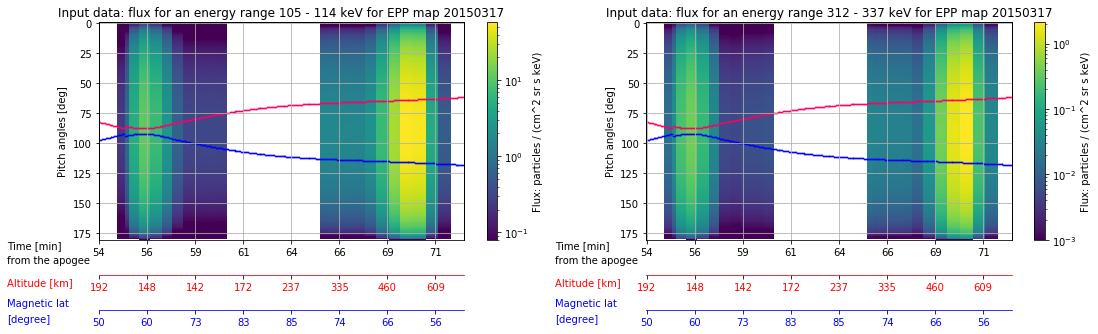

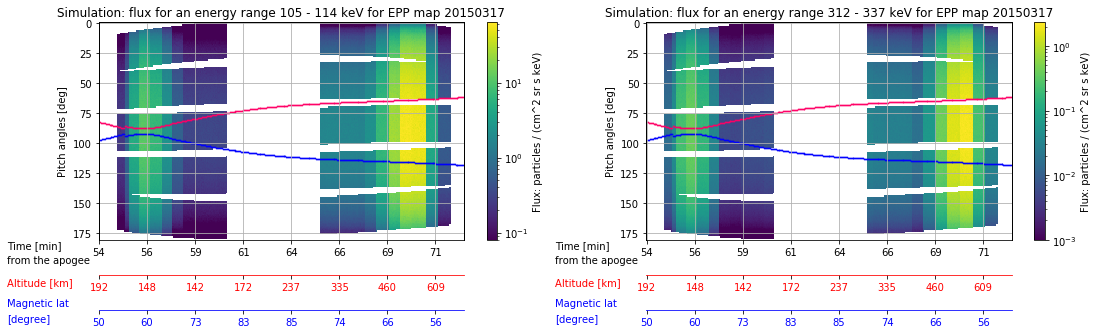

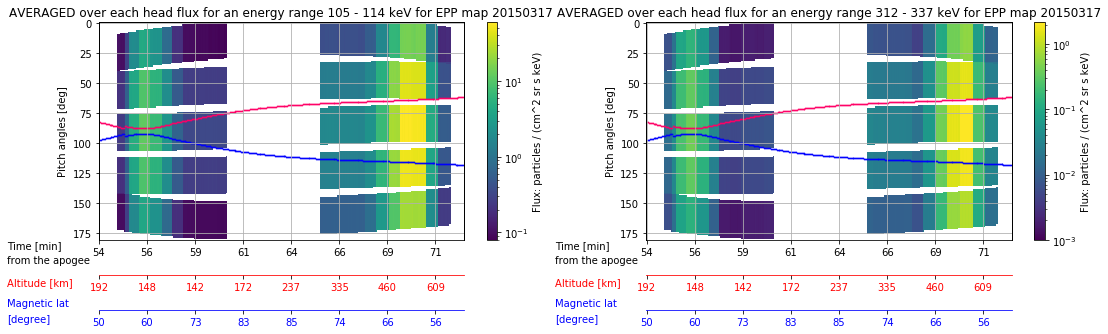

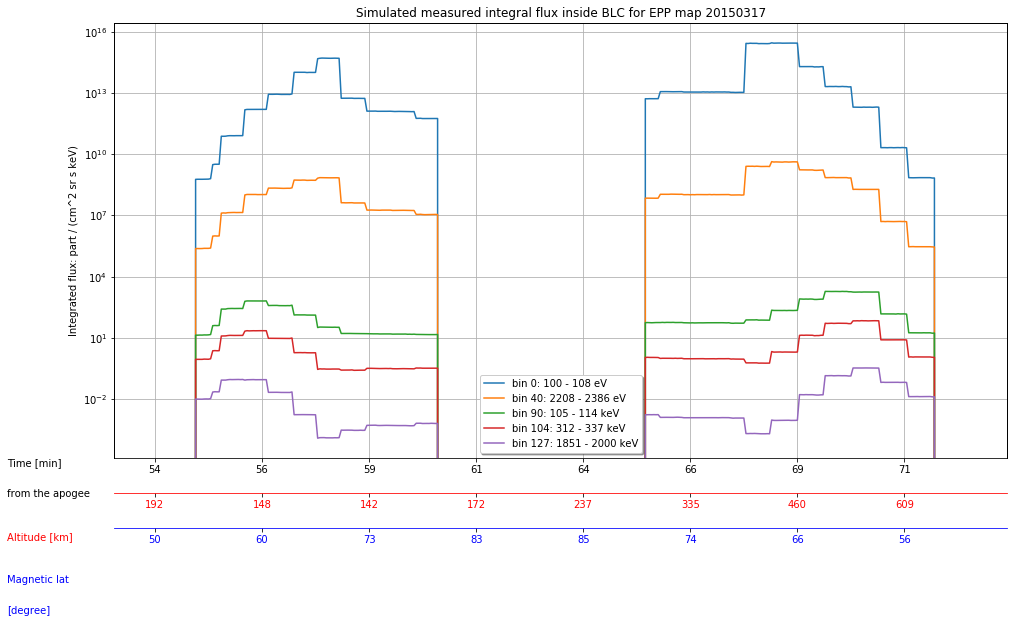

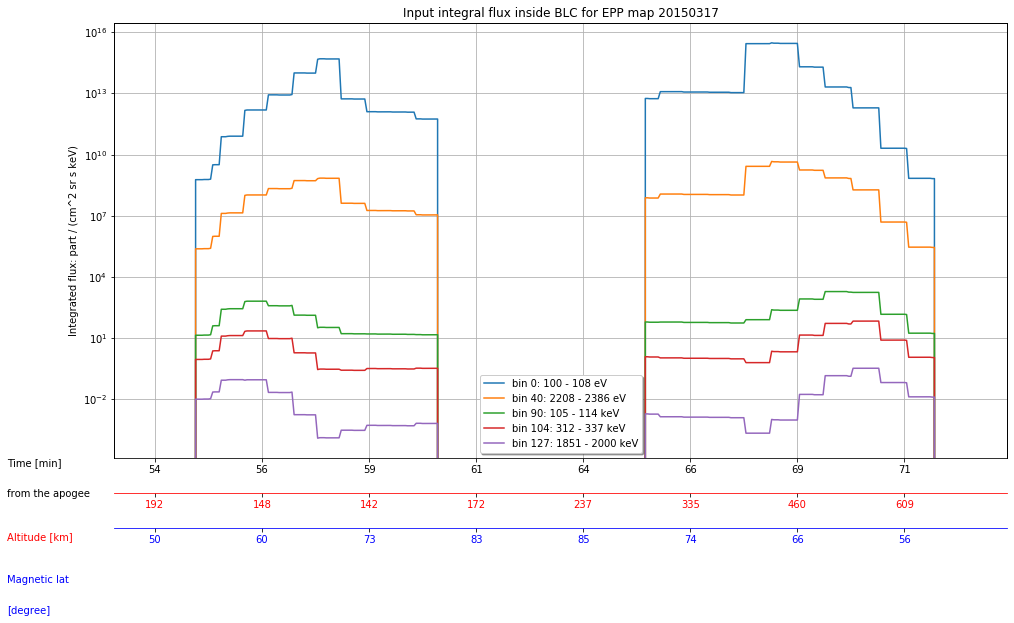

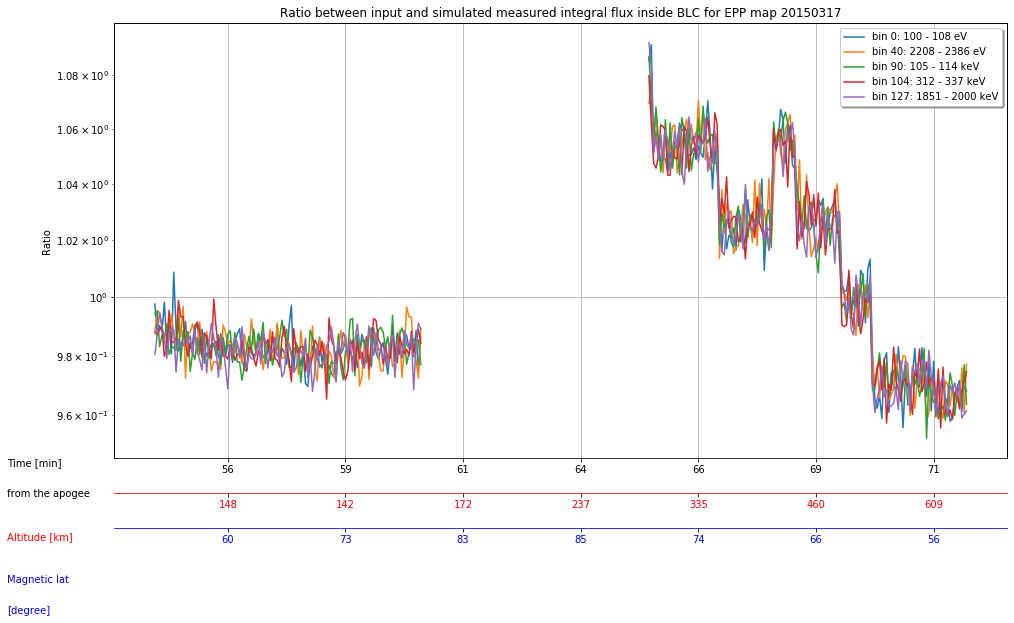

Loop is ok!


In [38]:
### main program, where I define all free parameters and which calls other functions

# Aperture angle in degrees (vertical for each head)
aperture = 30

# Number of heads
noh = 5

# Number of energy bins
nob = 128

# Number of pitch-angles
Npa = 181

# Determine which pitch angles are covered by each head. Here they are equally distributed from 0 to 180 
# relative to the vertical axis of the s/c (to the perpendicular to the Earth surface)
# Later depending on the current orientation of the B field the final coverege range of the pitch angles
# will depend on the magnetometer data. head centerhead_pointing - direction of the head central axes,
# head_opening - min and max value for pitch angle, covered by this head.
head_opening = np.zeros((noh, 2))
head_pointing = np.linspace(aperture/2, 180-aperture/2, noh)

# Previous map number (to check, which precipition map is already used and if the midnight is passed, to signalise, 
# that the new map should be used)    
map_name0 = 0

# Date and time for the precipition map
# Should be define for various scenarious (high solar activity, low solar activity)
year1 = 2015
month1 = 3
day1 = 17

Re = 6378    # [km] radius of the earth

atmo_height = 100 # [km] altitude of the atmosphere for BLC calculation

B0 = 30800   #[nT] for dipole magnetic field

# Here we define the name of file with precipitation map which should be used 
# (either we use already opened map, either we open the new map)
map_name = year1*10000+month1*100+day1
if map_name0 != map_name:
    # Here we upload to the memory the entire arrays for lat, long, var_c, var_k from this map
    # (one map for one day). Check the time resolution for the map in th create_input_output_matrix function
    # 1 min or 5 min
    lat, lon, var_c, var_k, mlat, mlon, Lshell = open_new_map(year1,month1,day1)
    map_name0 = map_name
        
#DAED_ORB_Evt1_LLA_Per120_Lat80_Srt01Hz_Msc_IGRF_all.csv
# Here I read the data from the Orbit file with IGRF model values for B
degree_sign= u'\N{DEGREE SIGN}'

#read file with orbit parameters
file_to_read=pd.read_csv("DAED_ORB_Evt0_LLA_Per140_Lat65_Srt01Hz_MSc_POS_VEL_IGRF.csv")
#read time and simply convert it in seconds in the form 1,2,3,....5000 etc
x1_axis_value_from_file = file_to_read["Time (UTCG)"]
time_sec_array = np.arange(len(x1_axis_value_from_file))

print(time_sec_array.shape, time_sec_array[0], time_sec_array[1], time_sec_array[7200])

#read the values for the 2nd x axis to be shown
x2_axis_value_from_file = file_to_read["Centric Lat (deg)"]
lat_sec_array = np.array(x2_axis_value_from_file,dtype=float)

#read the values for the 3nd x axis to be shown
x3_axis_value_from_file = file_to_read["Centric Lon (deg)"]
lon_sec_array = np.array(x3_axis_value_from_file,dtype=float)

#read the values for the 4nd x axis to be shown
x4_axis_value_from_file = file_to_read["Alt (km)"]
height_sec_array = np.array(x4_axis_value_from_file,dtype=float)

#read the values for the 5nd x axis to be shown
x5_axis_value_from_file = file_to_read["BMagnitude (nT)"]
Btotal_sec_array = np.array(x5_axis_value_from_file,dtype=float)

#read the values for the 6nd x axis to be shown
x6_axis_value_from_file = file_to_read["Bx (nT)"]
Bx_sec_array = np.array(x6_axis_value_from_file,dtype=float)

#read the values for the 7nd x axis to be shown
x7_axis_value_from_file = file_to_read["By (nT)"]
By_sec_array = np.array(x7_axis_value_from_file,dtype=float)

#read the values for the 8nd x axis to be shown
x8_axis_value_from_file = file_to_read["Bz (nT)"]
Bz_sec_array = np.array(x8_axis_value_from_file,dtype=float)

#read the values for the 9nd x axis to be shown
x9_axis_value_from_file = file_to_read["x (km)"]
x_sec_array = np.array(x9_axis_value_from_file,dtype=float)

#read the values for the 10nd x axis to be shown
x10_axis_value_from_file = file_to_read["y (km)"]
y_sec_array = np.array(x10_axis_value_from_file,dtype=float)

#read the values for the 11nd x axis to be shown
x11_axis_value_from_file = file_to_read["z (km)"]
z_sec_array = np.array(x11_axis_value_from_file,dtype=float)

#read the values for the 12nd x axis to be shown
x12_axis_value_from_file = file_to_read["Vx (km/sec)"]
vx_sec_array = np.array(x12_axis_value_from_file,dtype=float)

#read the values for the 13nd x axis to be shown
x13_axis_value_from_file = file_to_read["Vy (km/sec)"]
vy_sec_array = np.array(x13_axis_value_from_file,dtype=float)

#read the values for the 14nd x axis to be shown
x14_axis_value_from_file = file_to_read["Vz (km/sec)"]
vz_sec_array = np.array(x14_axis_value_from_file,dtype=float)

# Input and output matrixces number of pitch angles x number of energy bins
input_matrix = np.zeros((Npa,nob))
output_matrix = np.zeros((Npa,nob))

additional_fields_number = 11
output_angles_af = 10

### ### ### ### ### ### ### ### ### ### ### ### ### ###
### There are two options to run the code: to plot the figure for one perigiee / one orbit 
### or to prepare the file with the results for one day (or any other duration) for the further analysis.
### ### ### ### ### ### ### ### ### ### ### ### ### ###

### ### ### ### ### ### ### ### ### ### ### ### ### ###
### Option 1: to plot the figure
### ### ### ### ### ### ### ### ### ### ### ### ### ###

orb_q_0 = 1   #12 for the entire day (12 orbits)
res_size_0 = 380  ### 280 for perigee, 360 for entire orbit, len(vx_sec_array) for a file, 380 for 2015 and 08092017
start_sec_0 = 3250   ### 3400 ### 3625 for one point analysis, 3250 for 2015, 3270 for 08092017
res_step_0 = 3    ### 3 for perigee, 20 for orbit and 1 for the file

run_to_plot_figure(orb_q_0,res_size_0,start_sec_0,res_step_0)

# ### ### ### ### ### ### ### ### ### ### ### ### ### ###
# ### Option 2: to prepare the file
# ### ### ### ### ### ### ### ### ### ### ### ### ### ###

# orb_q_0 = 12   #12 for the entire day (12 orbits)
# res_size_0 = 7200  
# start_sec_0 = 0   
# res_step_0 = 1    

# run_to_write_into_the_file(orb_q_0,res_size_0,start_sec_0,res_step_0)
